基本的に、どちらの表記方法も数学的には同値ですが、$m_\infty$ と $\tau$（通常は $\tau_m$ と書かれる）の形で表現することにはいくつかの利点があります。

─────────────────────────────  
【1. 数学的等価性】

Hodgkin–Huxley型のゲート変数の時間発展は、しばしば以下の形で書かれます：

$$
\frac{dm}{dt} = \alpha_m (1 - m) - \beta_m m.
$$

この微分方程式の定常状態（$\frac{dm}{dt} = 0$）は

$$
m_\infty = \frac{\alpha_m}{\alpha_m + \beta_m}
$$

となり、また時間定数は

$$
\tau_m = \frac{1}{\alpha_m + \beta_m}
$$

と定義できます。これらを用いると、微分方程式は

$$
\frac{dm}{dt} = \frac{m_\infty - m}{\tau_m}
$$

という形に書き換えることができます。したがって、数式的にはどちらの形も同じダイナミクスを表しています。

─────────────────────────────  
【2. $m_\infty$ と $\tau_m$ を用いる利点】

1. **直感的な解釈**  
   - $m_\infty(V)$ は、特定の膜電位 $V$ におけるゲート変数の定常状態（すなわち、長時間その電位にとどまったときにチャネルがどれだけ開いているか）を直接示します。これは実験データと照らし合わせやすい量です。
   - $\tau_m(V)$ は、ゲート変数が新しい定常状態に到達する速さを表す時間定数であり、応答の速さや遅さを明示的に示します。

2. **実装とパラメータ調整の簡便性**  
   - 多くの実験データや文献では、$\alpha_m$ や $\beta_m$ そのものではなく、$m_\infty$ と $\tau_m$ の形で報告されることが多いです。モデル化の際に、直接これらの関数をフィッティングできるので、実際のデータとの対応が取りやすくなります。
   - また、電位依存性の評価が明示的になるため、どの電位範囲でチャネルがどの程度開くのか、または変化速度がどれほどかを個別に調整・解析しやすいというメリットがあります。

3. **数値シミュレーション上の利点**  
   - $m_\infty$ と $\tau_m$ の形に書き換えることで、シミュレーション中に各時刻で「目標値」と「追従速度」が明確になり、数値計算での直感的な誤差評価や安定性の確認に役立ちます。
   - 特にEuler法などのシンプルな数値解法を用いる際、更新式は
     $$
     m(t + \Delta t) = m(t) + \Delta t\,\frac{m_\infty(V)-m(t)}{\tau_m(V)}
     $$
     と書けるため、理解しやすく実装もシンプルです。

【3. 結論】

$\alpha_m (1-m) - \beta_m m$ という基本形はそのままでも計算可能ですが、$m_\infty = \frac{\alpha_m}{\alpha_m + \beta_m}$ と $\tau_m = \frac{1}{\alpha_m + \beta_m}$ を使って再表現することで、  
- ゲートの定常状態と時間スケールという観点から直感的に理解しやすくなる  
- 実験データとの比較やパラメータフィッティングが容易になる  
- シミュレーション実装上の利便性が向上する

といったメリットがあります。そのため、実装の際には多くの場合で$m_\infty$と$\tau_m$の形で表現されるのが一般的となっています。

In [1]:
using PyPlot

In [2]:
# Ca L-type channel
function CaLKineticsW(V)
    αm = 1.6 / (exp(-0.072 * (V - 5)) + 1)
    βm = 0.02 * (V + 8.69) / (exp((V + 8.69)/5.36) - 1)
    #m∞ = αm / (αm + βm)
    #τm = 1e-3 / (αm + βm)   # 単位 ms -> s に変換
    return m∞, τm
end

CaLKineticsW (generic function with 1 method)

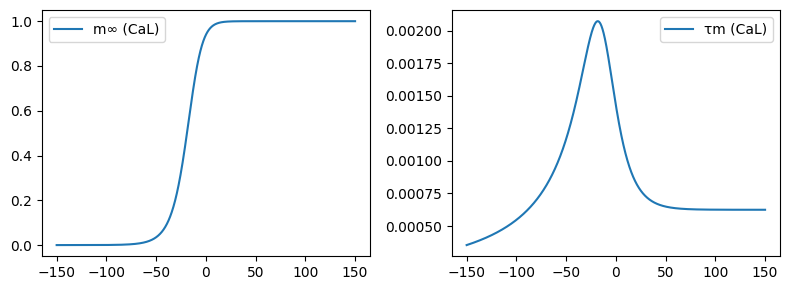

In [18]:
V = -150:0.1:150
res = CaLKineticsW.(V)
res = hcat(first.(res), last.(res))
m∞ = res[:, 1]
τm = res[:, 2]

figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m∞, label="m∞ (CaL)")
legend()
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
legend()
tight_layout()

In [19]:
# Non-specific cation current
function IhKinetics(V)
    αm = (6.43 * (V + 154)) / (exp((V + 154) / 11.9) - 1)
    βm = 193 * exp(V / 33.1)
    #m∞ = αm / (αm + βm)
    #τm = 1 / (αm + βm)
    return m∞, τm
end

IhKinetics (generic function with 1 method)

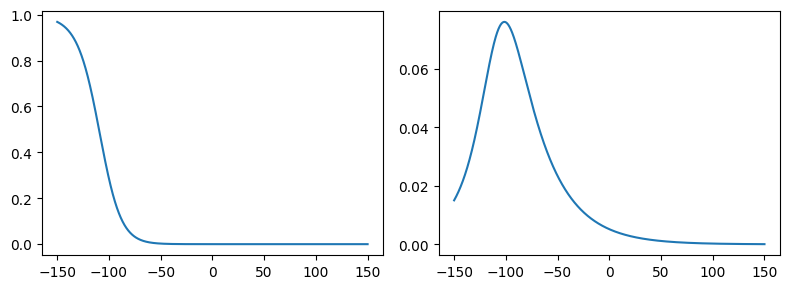

In [7]:
m∞ = similar(V)
τm = similar(V)
for i in eachindex(V)
    m∞[i], τm[i] = IhKinetics(V[i])
end
figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m∞, label="m∞ (CaL)")
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
tight_layout()

In [8]:
# Muscarinic K+ current
function ImKinetics(V)
    T_adj = 2.3^((34 - 21) / 10)
    αm = 0.0033 * exp(0.1 * (V + 35))
    βm = 0.0033 * exp(-0.1 * (V + 35))
    #m∞ = αm / (αm + βm)
    #τm = 1e-3 / (T_adj * (αm + βm))
    return m∞, τm
end

ImKinetics (generic function with 1 method)

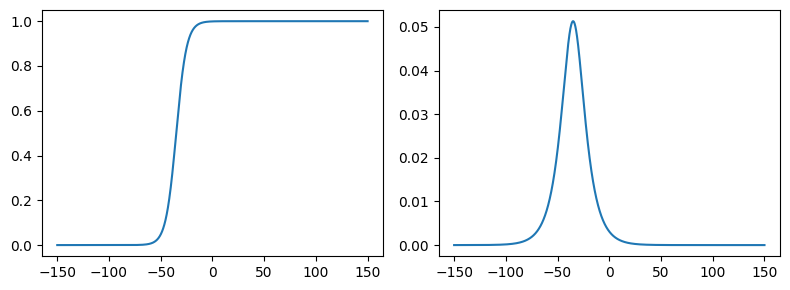

In [9]:
res = ImKinetics.(V)
res = hcat(first.(res), last.(res))
m∞ = res[:, 1]
τm = res[:, 2]

figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m∞, label="m∞ (CaL)")
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
tight_layout()

In [10]:
# Potassium delayed-rectifier
function KKinetics(V)
    αm = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
    βm = 0.125 * exp(-(V + 65) / 80)
    #m∞ = αm / (αm + βm)
    #τm = 1e-3 / (αm + βm)  # ms → s の変換
    return m∞, τm
end

KKinetics (generic function with 1 method)

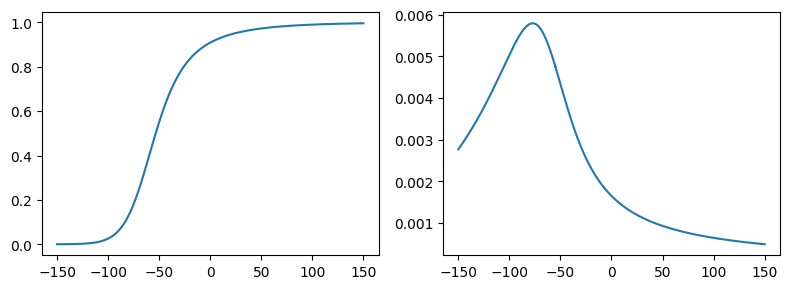

In [11]:
m∞ = similar(V)
τm = similar(V)
for i in eachindex(V)
    m∞[i], τm[i] = KKinetics(V[i])
end

figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m∞, label="m∞ (CaL)")
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
tight_layout()

In [12]:
# Slow inactivating K+ current
function KslowKinetics(V)
    T_adj = 2.3^((34 - 21) / 10)
    m∞ = 1 / (1 + exp(-(V + 11) / 12))
    h∞ = 1 / (1 + exp((V + 64) / 11))
    if V < -50
        τm = 1e-3 * (1.25 + 175.03 * exp(0.026 * (V + 10))) / T_adj
    else
        τm = 1e-3 * (1.25 + 13 * exp(-0.026 * (V + 10))) / T_adj
    end
    τh = 1e-3 * (360 + (1010 + 24 * (V + 65)) * exp(-((V + 85) / 48)^2)) / T_adj
    return m∞, τm, h∞, τh
end

KslowKinetics (generic function with 1 method)

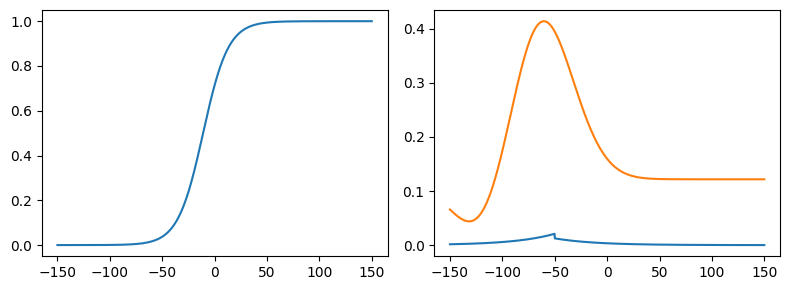

In [13]:
m∞ = similar(V)
τm = similar(V)
h∞ = similar(V)
τh = similar(V)
for i in eachindex(V)
    m∞[i], τm[i], h∞[i], τh[i] = KslowKinetics(V[i])
end
figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m∞, label="m∞ (CaL)")
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
plot(V, τh, label="τm (CaL)")
tight_layout()

In [14]:
# Sodium channel
function NaKinetics(V)
    αm = (V + 40) / (10 * (1 - exp(-(V + 40) / 10)))
    βm = 4 * exp(-(V + 65) / 18)
    m∞ = αm / (αm + βm)
    τm = 1e-3 / (αm + βm)
    
    αh = 0.07 * exp(-(V + 65) / 20)
    βh = 1 / (1 + exp(-(V + 35) / 10))
    h∞ = αh / (αh + βh)
    τh = 1e-3 / (αh + βh)
    return m∞, τm, h∞, τh
end

NaKinetics (generic function with 1 method)

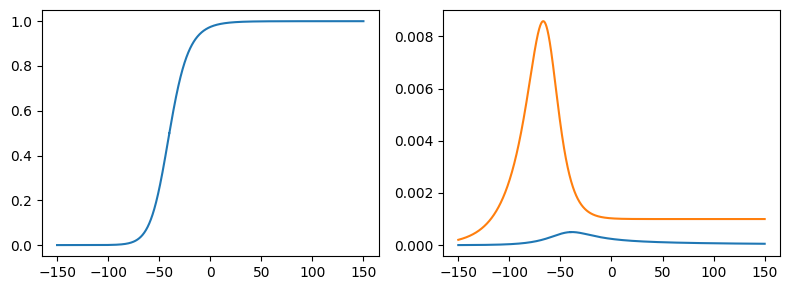

In [15]:
m∞ = similar(V)
τm = similar(V)
h∞ = similar(V)
τh = similar(V)
for i in eachindex(V)
    m∞[i], τm[i], h∞[i], τh[i] = NaKinetics.(V[i])
end

figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m∞, label="m∞ (CaL)")
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
plot(V, τh, label="τm (CaL)")
tight_layout()

In [16]:
# 実装？
function NapKinetics(V)
    T_adj = 2.3^((34 - 21) / 10)

    #αm = 0.182 * (V + 38) / (1 - exp(-(V + 38) / 6))
    #βm = -0.124 * (V + 38) / (1 - exp((V + 38) / 6))
    m∞ = 1 / (1 + exp(-(V + 52.6) / 4.6))
    τm = 1e-3 * 6 / (T_adj * (αm + βm))
    
    #αh = -2.88e-6 * (V + 17) / (1 - exp((V + 17) / 4.63))
    #βh  = 6.94e-6 * (V + 64.4) / (1 - exp(- (V + 64.4) / 2.63))
    h∞ = 1 / (1 + exp((V + 48.8) / 10))
    τh = 1e-3 / (T_adj * (αh + βh))
    return m∞, τm, h∞, τh
end

NapKinetics (generic function with 1 method)

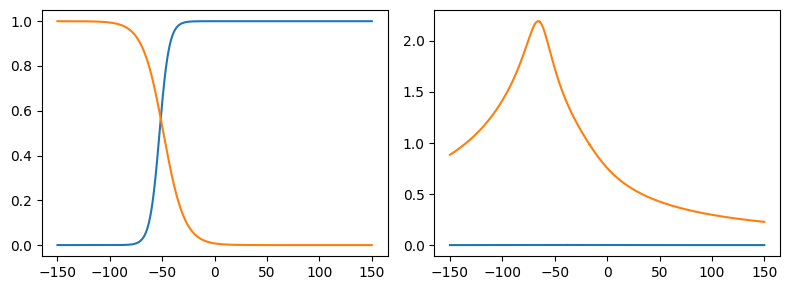

In [17]:
m = similar(V)
τm = similar(V)
h = similar(V)
τh = similar(V)
for i in eachindex(V)
    m[i], τm[i], h[i], τh[i] = NapKinetics(V[i])
end
figure(figsize=(8,3))
subplot(1,2,1)
plot(V, m, label="m∞ (CaL)")
plot(V, h, label="m∞ (CaL)")
subplot(1,2,2)
plot(V, τm, label="τm (CaL)")
plot(V, τh, label="τm (CaL)")
tight_layout()